# Requirements

- make sure you have python-igraph installed
- set the directory in next cell

In [1]:
## path to datasets
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

Just looking at basic statistics on degree distribution, clustering coefficient and shortest paths, we can identify huge difference between different types of graphs. Here we look at a social-type graph, and a transportation-type (power grid) network.

## GitHub Developers (undirected)

Description

A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.


In [3]:
## read the GitHub edge list into a graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

## Europe Electric Grid

Network of high voltage grid in Europe. Details at:
https://zenodo.org/record/47317#.Xt6nzy3MxTY



In [4]:
## read edge list for the grid network
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

## Features for 4 graphs

- GitHub
- GitHub ml developers
- GitHub web developers
- Grid

In [5]:
## for github, 9739 are ml developers, and xxx are web developers;
## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

In [6]:
## github graph: count ml with connection to web only and vice-versa
c_ml = c_web = 0
for v in gh.vs():
    if v['lbl']=='ml':
        if set([gh.vs[i]['lbl'] for i in gh.neighbors(v)])=={'web'}:
            c_ml+=1
    else:
        if set([gh.vs[i]['lbl'] for i in gh.neighbors(v)])=={'ml'}:
            c_web+=1
print(c_ml,'ml connected only to web and',c_web,'web connected only to ml')        

2308 ml connected only to web and 285 web connected only to ml


In [7]:
## compute and store basic stats in a table
## this can take a few minutesS = []
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters().membership)+1,G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['GitHub'] + baseStats(gh))
S.append(['GitHub (ml)'] + baseStats(gh_ml))
S.append(['GitHub (web)'] + baseStats(gh_web))
S.append(['Grid'] + baseStats(gr))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

,0,1,2,3
graph,GitHub,GitHub (ml),GitHub (web),Grid
nodes,37700,9739,27961,13844
edges,289003,19684,224623,17277
$d_{min}$,1,0,0,1
$d_{mean}$,15.3317,4.0423,16.0669,2.49595
$d_{median}$,6,2,6,2
$d_{quant_{99}}$,138.01,39,145,8
$d_{max}$,9458,482,8194,16
diameter,11,13,9,147
components,1,2466,297,59


In [8]:
## To produce LaTeX from a DataFrame
#df = D.round(decimals=3)
#print(df.to_latex(index=True))

## Visualize part of the Grid network

1562 nodes


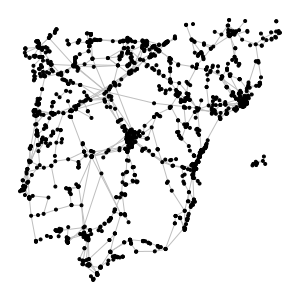

In [9]:
## subgraph of Grid -- Iberic peninsula
V = [v for v in gr.vs() if v['latitude']>36 and v['latitude']<44 and v['longitude']>-10 and v['longitude']<4]
gr_spain = gr.subgraph(V)
ly = ig.Layout(gr_spain.vs['layout'])
ly.mirror(1)
print(gr_spain.vcount(),'nodes')
#ig.plot(gr_spain, 'grid_sg.eps', layout=ly, bbox=(0,0,300,300))
ig.plot(gr_spain, layout=ly, bbox=(0,0,300,300))


## Visualize part of the GitHub (ml) graph

Quite different from the Grid graph, with clumps (dense areas) and less regular edge distribution

In [10]:
## plot subgraph for github(ml)
sg = gh_ml.clusters().giant()
ly = sg.layout_auto()
sg.vs['x'] = [x[0] for x in ly]
sg.vs['y'] = [x[1] for x in ly]


987


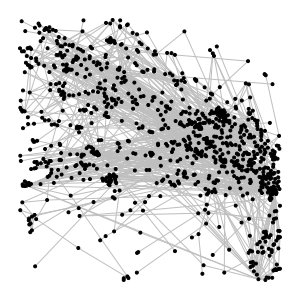

In [11]:
z = 52 ## adjust to zoom in or out
V = [v for v in sg.vs() if v['x']<z and v['x']>-z and v['y']<z and v['y']>-z]
ssg = sg.subgraph(V).clusters().giant()
ssg.vs['size'] = 3
print(ssg.vcount())
#ig.plot(ssg, 'github_ml_sg.eps',bbox=(0,0,300,300))
ig.plot(ssg,bbox=(0,0,300,300))

## Visualize part of the GitHub (web) graph

This can be slow!

In [12]:
## plot subgraph for github (web)
sg = gh_web.clusters().giant()
ly = sg.layout_auto()
sg.vs['x'] = [x[0] for x in ly]
sg.vs['y'] = [x[1] for x in ly]


In [1]:
## you can try various zoom as this will vary
z = 60
V = [v for v in sg.vs() if v['x']<z and v['x']>-z and v['y']<z and v['y']>-z]
ssg = sg.subgraph(V).clusters().giant()
ssg.vs['size'] = 3
ssg.vs['color'] = 'black'
print(ssg.vcount(),'nodes')
#ig.plot(ssg, 'github_web_sg.eps',bbox=(0,0,300,300))
ig.plot(ssg,bbox=(0,0,300,300))

NameError: name 'sg' is not defined

## Compare degree distributions

We plot the (empirical) cumulative distribution functions (cdf)

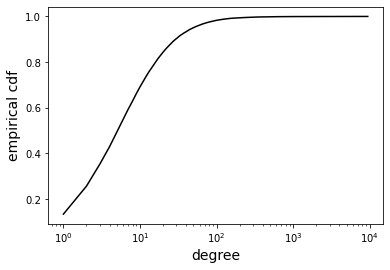

In [14]:
## degree distribution - GitHub graph
deg = gh.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='black',label='GitHub')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gh.eps');


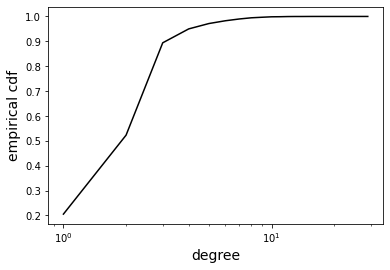

In [15]:
## degree distribution - Grid graph
## we see much lower degree here
deg = gr.degree()
e = ecdf(deg)
x = np.arange(1,30,1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='black',label='Grid')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gr.eps');


## Shortest paths distribution

Histograms of shortest path lengths from 100 random nodes;

again we see much different distributions



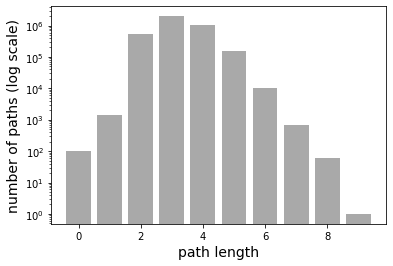

In [16]:
## shortest paths length from a given node, GitHub graph
from collections import Counter
sg = gh.clusters().giant()
V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample
sp = []
for v in V:
    sp.extend(sg.shortest_paths(source=v)[0])
c = Counter(sp)
s = sorted(c.items())

fig, ax = plt.subplots()
x = [x[0] for x in s]
y = [x[1] for x in s]
b = ax.bar(x, y, color='darkgrey') 

ax.set_yscale('log')

ax.set_xlabel('path length',fontsize=14)
ax.set_ylabel('number of paths (log scale)',fontsize=14);
#plt.savefig('pathlen_github.eps');


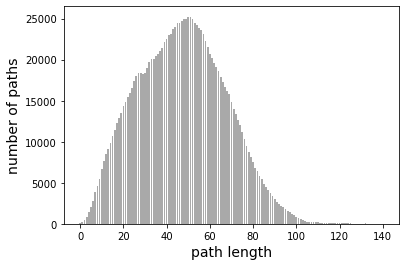

In [17]:
## min path length from that node to other nodes, Grid network
sg = gr.clusters().giant()
V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample
sp = []
for v in V:
    sp.extend(sg.shortest_paths(source=v)[0])
c = Counter(sp)
s = sorted(c.items())

fig, ax = plt.subplots()
x = [x[0] for x in s]
y = [x[1] for x in s]
b = ax.bar(x, y, color='darkgrey') 
ax.set_xlabel('path length',fontsize=14)
ax.set_ylabel('number of paths',fontsize=14);
#plt.savefig('pathlen_grid.eps');


## Local clustering coefficient

We compare the average local clustering coefficients as a function
of the degree. We consider degrees from 10 to 1000.


In [18]:
## build dataframe with degrees and local clustering coefficients
## and compute mean values w.r.t. degree.
## GitHub graph
mindeg = 10
maxdeg = 1000
D = pd.DataFrame(np.array([gh.transitivity_local_undirected(),gh.degree()]).transpose(),
            columns=['CC','d'])
C = D[D['d']>=mindeg].groupby(by='d').mean()
deg = list(C.index)
l = sum([i<=maxdeg for i in deg])
deg = deg[:l]
clust = list(C['CC'])[:l]


power law exponent: -0.7159837009746673


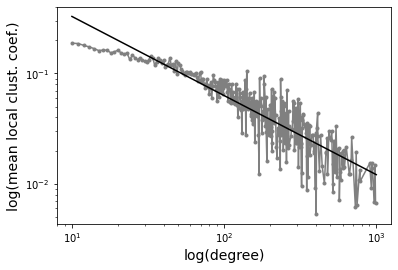

In [19]:
# Fit a regression (log-log scale) and plot
regressor = LinearRegression()  
x = [np.log(i) for i in deg]
y = [np.log(i) for i in clust]
regressor.fit(np.array(x).reshape(-1,1), y)
print('power law exponent:',regressor.coef_[0])
## plot on log-log scale
b = regressor.intercept_
a = regressor.coef_[0]
plt.loglog(deg,clust,'.-',color='grey')
plt.plot([mindeg,maxdeg],[np.exp(b)*mindeg**a,np.exp(b)*maxdeg**a],color='black')
plt.xlabel('log(degree)',fontsize=14)
plt.ylabel('log(mean local clust. coef.)',fontsize=14);
#plt.savefig('localCC.eps');